# PyTorch getting started with MNIST
We use the (in)famous MNIST handwritten digits dataset for our first CNN.

In [1]:
import torch

# We use torchvision to get our dataset and useful image transformations
import torchvision
import torchvision.transforms as transforms

# nn is used as the basic building block for our Network graphs
import torch.optim as optim
import torch.nn as nn

# check if cuda is usable
if torch.cuda.is_available():
  device = 'cuda' 
else:
  device = 'cpu' 

print(f"Using device: {device}")

Using device: cpu


In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from lib.imageutil import show_image

## Transform to tensor

In [3]:
# transform to a tensor and normalize between -1, +1
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, ), (0.5, ))])

## Get the dataset
A lot of the usual datasets are already public available in pytorch.

In [4]:
trainset = torchvision.datasets.MNIST(root = './tmp/mnist', 
                                      train = True, 
                                      download = True,
                                      transform = transform)

testset = torchvision.datasets.MNIST(root = './tmp/mnist', 
                                     train = False,
                                     download = True,
                                     transform = transform)

# 60,000 training samples & 10,000 testsamples each 28 x 28 pixels grayscale
print(f'train: {trainset.data.shape}')
print(f'test: {testset.data.shape}')

train: torch.Size([60000, 28, 28])
test: torch.Size([10000, 28, 28])


## Show a sample

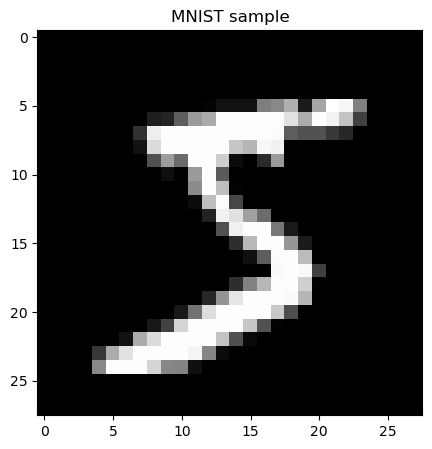

In [5]:
# as this is a tensor, we need to convert to a numpy array first
image = trainset.data[0].numpy()
show_image(image, "MNIST sample")

## Create dataloader
Dataloaders allow us to get samples from a dataset in a specific way, i.e. shuffled, in batches or parallel.

In [6]:
trainloader = torch.utils.data.DataLoader(trainset,
                                           batch_size = 64,
                                           shuffle = True,
                                           num_workers = 0)

testloader = torch.utils.data.DataLoader(testset,
                                          batch_size = 64,
                                          shuffle = False,
                                          num_workers = 0)

In [7]:
# we can use the python iter()-function to get an iterator
train_iterator = iter(trainloader)

images, labels = next(train_iterator)

print(f'images shape: {images.shape}')
print(f'labels shape: {labels.shape}')

images shape: torch.Size([64, 1, 28, 28])
labels shape: torch.Size([64])


## Define the model
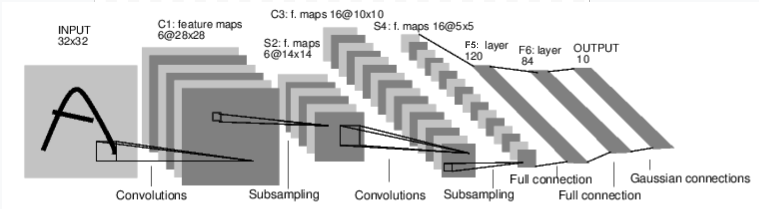

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_1 = nn.Conv2d(1, 32, 3)
        self.conv_2 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc_1 = nn.Linear(64 * 12 * 12, 128)
        self.fc_2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = self.pool(F.relu(self.conv_2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x

In [9]:
net = Net()
net.to(device)

Net(
  (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=9216, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
)

## Loss function and optimizer

In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

# we use Stochastic Gradient Descent (SGD)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Training loop

In [11]:
epochs = 5

epoch_log = []
loss_log = []
accuracy_log = []

for epoch in range(epochs):
    print(f'Epoch {epoch + 1} starting!')

    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # clear the gradients
        optimizer.zero_grad()

        # forward pass
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        # backpropagation and update of weights
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # run against test dataset
        if i % 50 == 49:
            correct = 0
            total = 0

            # no gradients needed for testing
            with torch.no_grad():
                for images, labels in testloader:
                    images = images.to(device)
                    labels = labels.to(device)
                    
                    outputs = net(images)

                     # predictions from the maximum value of the predicted output tensor
                     # we set dim = 1 to reduce the dimensions
                    _, predicted = torch.max(outputs.data, dim = 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                accuracy = 100 * correct / total
                epoch_num = epoch + 1
                actual_loss = running_loss / 50
                print(f'Epoch: {epoch_num}, Batches completed: {(i+1)}, Loss: {actual_loss:.3f}, Test Accuracy = {accuracy:.3f}%')
                running_loss = 0.0
    
    # update logs after each epoch
    epoch_log.append(epoch_num)
    loss_log.append(actual_loss)
    accuracy_log.append(accuracy)
    
print('Training done!')

Epoch 1 starting!
Epoch: 1, Batches completed: 50, Loss: 2.251, Test Accuracy = 32.670%
Epoch: 1, Batches completed: 100, Loss: 2.005, Test Accuracy = 65.820%
Epoch: 1, Batches completed: 150, Loss: 1.251, Test Accuracy = 79.020%
Epoch: 1, Batches completed: 200, Loss: 0.647, Test Accuracy = 83.190%
Epoch: 1, Batches completed: 250, Loss: 0.507, Test Accuracy = 86.190%
Epoch: 1, Batches completed: 300, Loss: 0.529, Test Accuracy = 86.600%
Epoch: 1, Batches completed: 350, Loss: 0.501, Test Accuracy = 86.070%
Epoch: 1, Batches completed: 400, Loss: 0.438, Test Accuracy = 86.750%
Epoch: 1, Batches completed: 450, Loss: 0.436, Test Accuracy = 88.500%
Epoch: 1, Batches completed: 500, Loss: 0.398, Test Accuracy = 87.620%
Epoch: 1, Batches completed: 550, Loss: 0.424, Test Accuracy = 87.250%
Epoch: 1, Batches completed: 600, Loss: 0.397, Test Accuracy = 89.080%
Epoch: 1, Batches completed: 650, Loss: 0.349, Test Accuracy = 89.640%
Epoch: 1, Batches completed: 700, Loss: 0.358, Test Accuracy

## Saving the trained model
We can use the `torch.save()` function to save our model.
`
net.state_dict`() sav theur model weights in a dictionay format.

In [12]:
model_path = './out/mnist_cnn_net.pth'
#torch.save(net.state_dict(), model_path)

## Reloading the model

In [13]:
net = Net()
net.to(device)

# Load weights from the specified path
net.load_state_dict(torch.load(model_path))

<All keys matched successfully>

## Predict
We should set `net.eval()` and `torch.no_grad()` when evaluating to save memory and set
appropriate switches on the network that are only relevant during training.

In [14]:
number_of_classes = 10

classes_correct = list(0. for i in range(number_of_classes))
classes_total = list(0. for i in range(number_of_classes))

net.eval()
with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = net(images)

        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        
        for i in range(number_of_classes):
            label = labels[i]
            classes_correct[label] += c[i].item()
            classes_total[label] += 1


for i in range(number_of_classes):
    class_accuracy = 100 * classes_correct[i] / classes_total[i]
    print(f'Class-cccuracy of {i} : {class_accuracy:.3f}%')

Class-cccuracy of 0 : 97.368%
Class-cccuracy of 1 : 98.378%
Class-cccuracy of 2 : 95.930%
Class-cccuracy of 3 : 96.795%
Class-cccuracy of 4 : 97.740%
Class-cccuracy of 5 : 97.619%
Class-cccuracy of 6 : 96.875%
Class-cccuracy of 7 : 97.561%
Class-cccuracy of 8 : 97.203%
Class-cccuracy of 9 : 97.006%


## Confusion matrix

In [18]:
from sklearn.metrics import confusion_matrix

prediction_list = torch.zeros(0, dtype = torch.long, device = 'cpu')
label_list = torch.zeros(0, dtype = torch.long, device = 'cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)

        prediction_list = torch.cat([prediction_list, preds.view(-1).cpu()])
        label_list = torch.cat([label_list, classes.view(-1).cpu()])

# Confusion matrix
conf_mat = confusion_matrix(label_list.numpy(), prediction_list.numpy())
print(f'confusion matrix: \r\n{conf_mat}')

confusion matrix: 
[[ 965    0    1    0    0    3    4    1    3    3]
 [   0 1130    2    1    0    1    1    0    0    0]
 [   2    7 1003    3    3    0    2    4    8    0]
 [   0    0    2  989    0    6    0    5    7    1]
 [   1    1    3    0  959    0    7    0    2    9]
 [   1    0    0    5    0  879    4    1    2    0]
 [   6    4    0    0    4    6  933    0    5    0]
 [   1    7   12    4    0    0    0  996    3    5]
 [   4    0    1    4    2    5    1    3  952    2]
 [   2    7    0    4    9    8    1    9    3  966]]


We can also use a helper function to plot the confusion matrix as image.  
http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

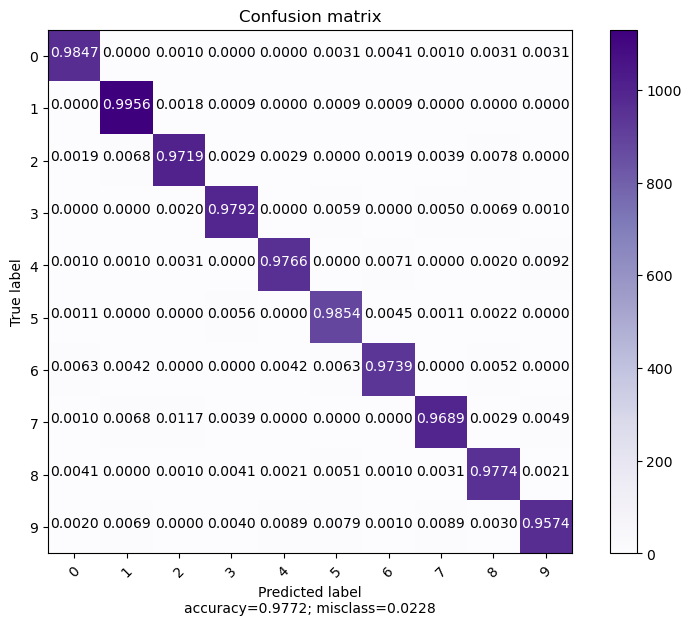

In [41]:
import matplotlib.pyplot as plt
from lib.report import plot_confusion_matrix

target_names = list(range(0,10))
plot_confusion_matrix(conf_mat, target_names, cmap=plt.get_cmap('Purples'))

## Classification report

In [19]:
from sklearn.metrics import classification_report

print(classification_report(label_list.numpy(), prediction_list.numpy()))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.98      1.00      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.97      0.99      0.98       892
           6       0.98      0.97      0.98       958
           7       0.98      0.97      0.97      1028
           8       0.97      0.98      0.97       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

